In [1]:
import dagshub
dagshub.init(repo_owner='dakshvandanarathi', repo_name='YT-Sentiment-Analyser', mlflow=True)

Accessing as dakshvandanarathi

Initialized MLflow to track repo "dakshvandanarathi/YT-Sentiment-Analyser"

Repository dakshvandanarathi/YT-Sentiment-Analyser initialized!

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, ClusterCentroids, NearMiss)
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE)
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Set or create an experiment
mlflow.set_experiment("Exp 3 - Imbalanced Data")

2024/10/22 14:05:43 INFO mlflow.tracking.fluent: Experiment with name 'Exp 3 - Imbalanced Data' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/e922f13bc1d04ef689987f90d2d987d1', creation_time=1729605944111, experiment_id='4', last_update_time=1729605944111, lifecycle_stage='active', name='Exp 3 - Imbalanced Data', tags={}>

In [4]:
df = pd.read_csv('/content/preprocessed_data.csv')
df.shape

(36662, 5)

In [5]:
# Define a function to vectorize the data using TF-IDF
def vectorize_data(X_train, X_test, max_features, ngram_range):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_train_vec = vectorizer.fit_transform(X_train['comment']).toarray()
    X_test_vec = vectorizer.transform(X_test['comment']).toarray()

    # Combine additional features
    X_train_combined = np.hstack([X_train_vec, X_train[['word_count', 'char_count', 'avg_word_length']].values])
    X_test_combined = np.hstack([X_test_vec, X_test[['word_count', 'char_count', 'avg_word_length']].values])

    return X_train_combined, X_test_combined

In [6]:
max_features = 1006
ngram_range = (1, 2)

# Split data into training and testing sets
X = df[['comment', 'word_count', 'char_count', 'avg_word_length']]
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the data
X_train_combined, X_test_combined = vectorize_data(X_train, X_test, max_features, ngram_range)

In [7]:
# Define a function to apply different resampling techniques
def resample_data(X_train, y_train, technique):
    if technique == 'class_weight':
        class_weight = 'balanced'
        return X_train, y_train, class_weight
    else:
        class_weight = None
        if technique == 'random_undersampling':
            sampler = RandomUnderSampler(random_state=42)
        elif technique == 'tomek_links':
            sampler = TomekLinks()
        elif technique == 'centroid_clustering':
            sampler = ClusterCentroids(random_state=42)
        elif technique == 'nearmiss_undersampling':
            sampler = NearMiss()
        elif technique == 'random_oversampling':
            sampler = RandomOverSampler(random_state=42)
        elif technique == 'smote':
            sampler = SMOTE(random_state=42)
        elif technique == 'adasyn':
            sampler = ADASYN(random_state=42)
        elif technique == 'borderline_smote':
            sampler = BorderlineSMOTE(random_state=42)
        elif technique == 'smotetomek':
            sampler = SMOTETomek(random_state=42)
        elif technique == 'smotenn':
            sampler = SMOTEENN(random_state=42)
        else:
            raise ValueError("Unknown resampling technique")

        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        return X_resampled, y_resampled, class_weight

# List of resampling techniques to try, including SMOTEENN
resampling_techniques = [
    'random_undersampling', 'tomek_links', 'centroid_clustering', 'nearmiss_undersampling',
    'random_oversampling', 'smote', 'adasyn', 'borderline_smote', 'smotetomek', 'smotenn', 'class_weight'
]

2024/10/22 14:06:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run rf_tfidf_random_undersampling at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/4/runs/c771e3a9666d41c496555ec03058141f.
2024/10/22 14:06:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/4.
2024/10/22 14:08:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run rf_tfidf_tomek_links at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/4/runs/bc20768171eb45d598da581cb29805d6.
2024/10/22 14:08:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/4.
2024/10/22 14:18:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run rf_tfidf_centroid_clustering at: https://dagshub.com/dakshvandanarathi/YT-Sentiment-Analyser.mlflow/#/experiments/4/r

Resampling experiments complete.


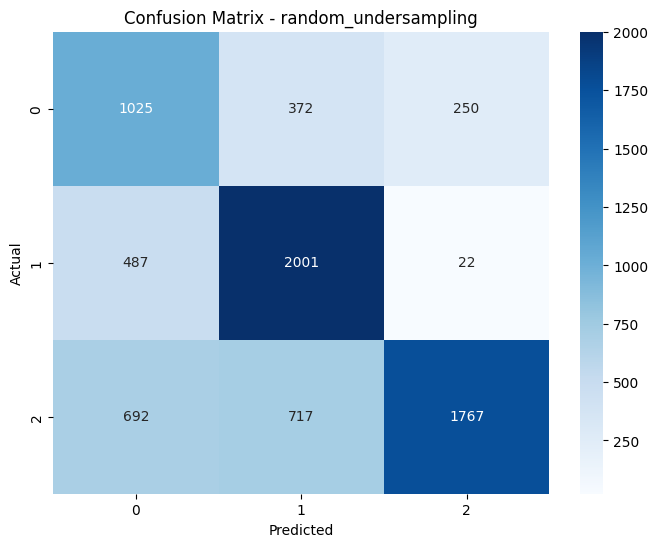

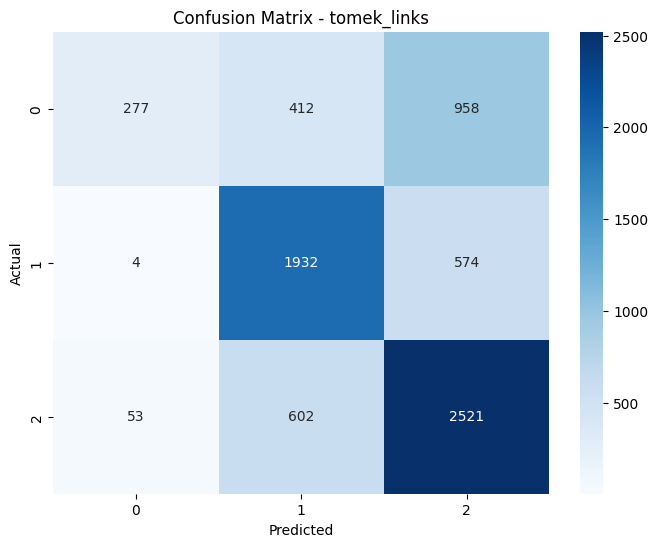

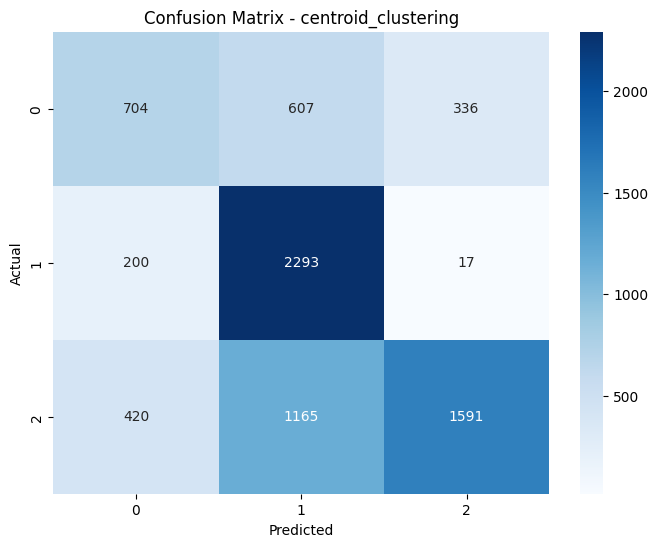

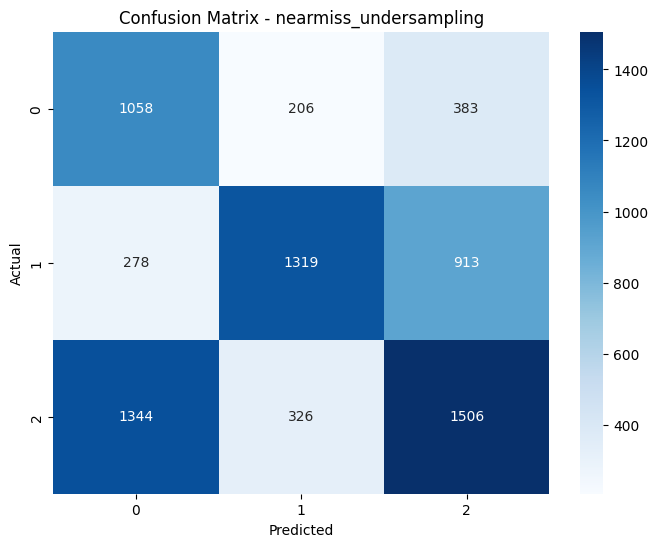

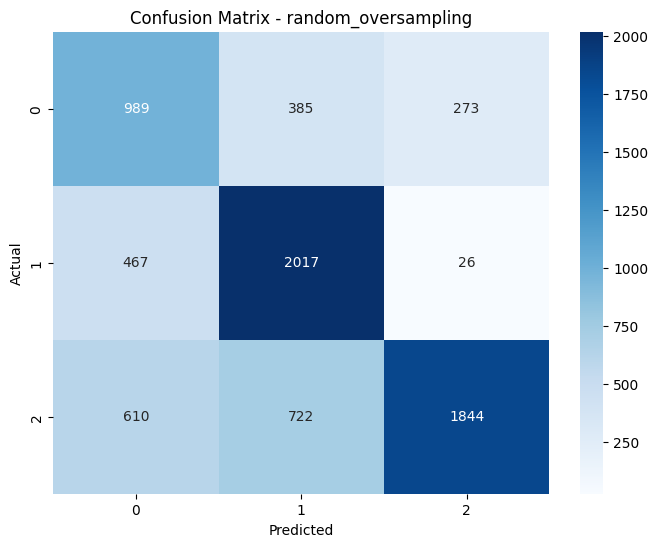

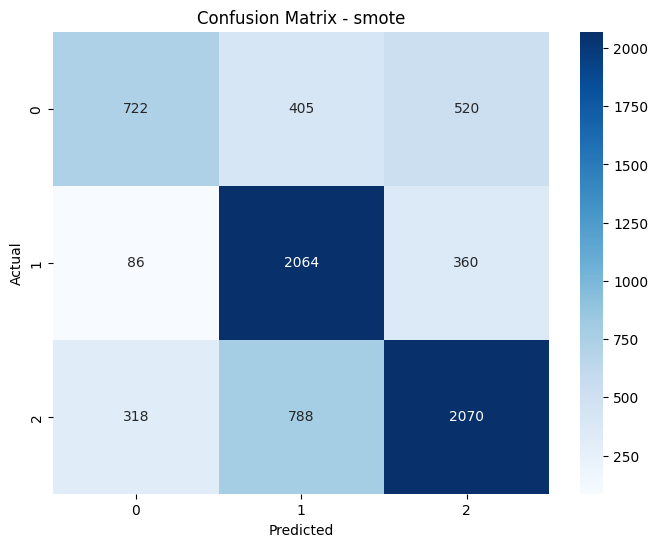

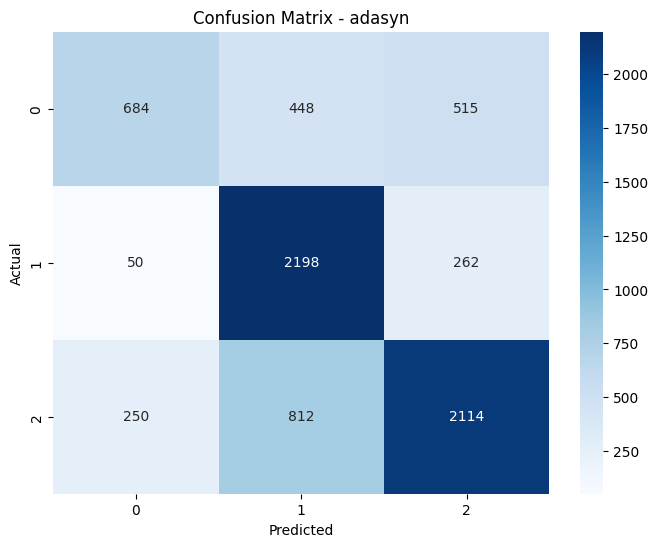

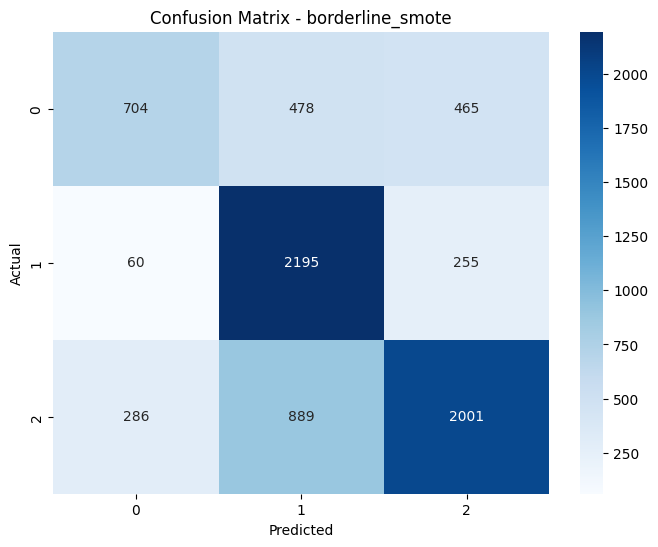

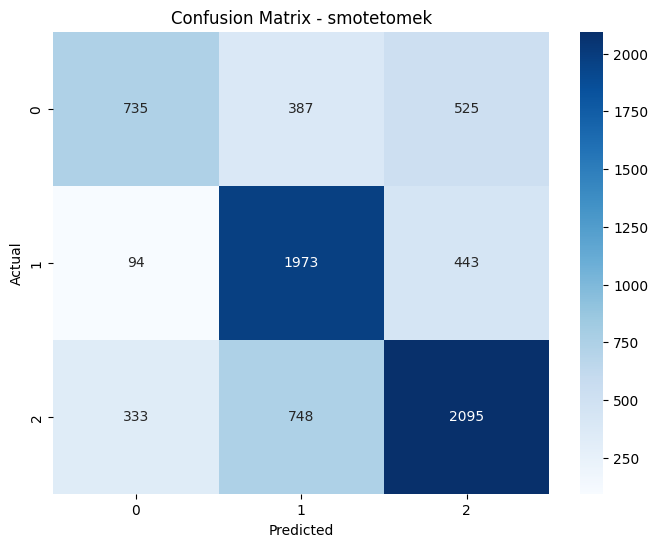

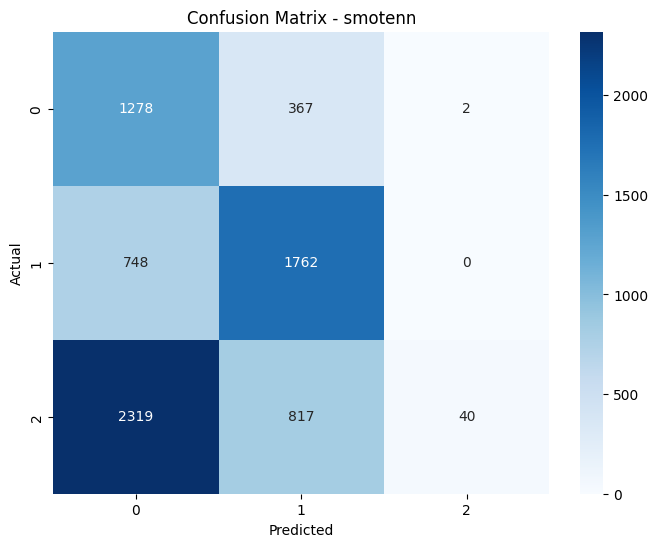

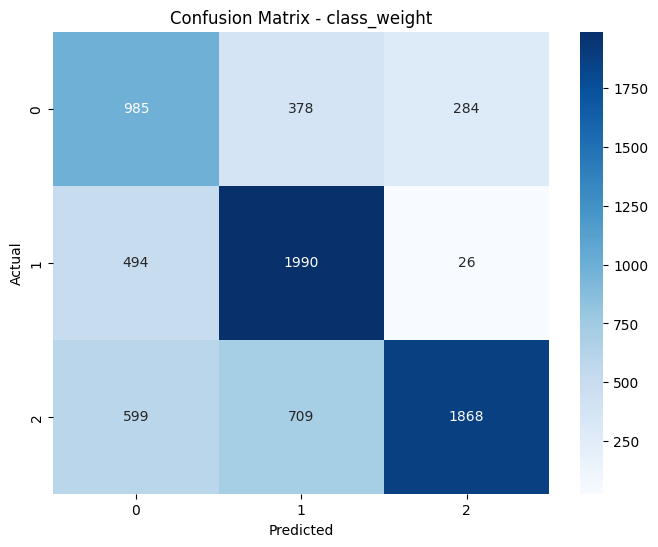

In [8]:
# Loop through each technique and train a RandomForest model
for technique in resampling_techniques:
    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"rf_tfidf_{technique}")
        mlflow.set_tag("resampling_technique", technique)
        mlflow.set_tag("model_type", "RandomForestClassifier")
        mlflow.set_tag("vectorizer_type", "TF-IDF")

        # Log the best parameters from Optuna
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("resampling_technique", technique)

        # Apply resampling technique
        X_train_resampled, y_train_resampled, class_weight = resample_data(X_train_combined, y_train, technique)

        # Train Random Forest Classifier
        model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight=class_weight)
        model.fit(X_train_resampled, y_train_resampled)

        # Make predictions on the test set
        y_pred = model.predict(X_test_combined)

        # Log metrics
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)

        mlflow.log_metric("accuracy", accuracy)

        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Confusion matrix plot
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {technique}")

        # Save and log the confusion matrix plot
        plt.savefig(f"confusion_matrix_{technique}.png")
        mlflow.log_artifact(f"confusion_matrix_{technique}.png")

# End of the experiment
print("Resampling experiments complete.")